<a href="https://colab.research.google.com/github/xc308/DeepLearning_Lab/blob/main/LLM_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Large Language Model (LLM) Fine-tuning

- fine-tune a multi-billion parameter large language model (LLM)

- fundamental concepts of LLMs, including tokenization, templates, and fine-tuning

- ways to evaluate the performance of a language model

- use Google's Gemma 2B model as the base language model to fine-tune

-  Liquid AI's LFM-40B as an evaluation "judge" model

- Comet ML's Opik as a framework for streamlined LLM evaluation

-

In [2]:
# Install and import MIT Deep Learning utilities
!pip install mitdeeplearning > /dev/null 2>&1
import mitdeeplearning as mdl

In [3]:
#with tqdm() to create a progress bar that shows the progress of your iteration in real-time.

import os
import json
from tqdm import tqdm # create monitor bar for iterable list or strings
import matplotlib.pyplot as plt
import numpy as np


import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader


import torch       # tools for deep learning, tensor computations, and GPU acceleration.
from torch.nn import functional as F        # provides stateless functions like activation functions (F.relu, F.softmax), loss functions (F.cross_entropy)
from torch.utils.data import DataLoader     # helps in loading datasets efficiently by batching, shuffling, and parallel processing.
                                            # It is commonly used for iterating over large datasets in deep learning.


from transformers import AutoTokenizer, AutoModelForCausalLM    #  Hugging Face Transformers library, which provides pre-trained models for NLP tasks. AutoTokenizer: Automatically loads a tokenizer for a specific model; AutoModelForCausalLM: Loads a model for causal language modeling, meaning it predicts the next word in a sequence (used in text generation, e.g., ChatGPT).
from datasets import load_dataset                               #
from peft import LoraConfig, get_peft_model                     # From the PEFT (Parameter-Efficient Fine-Tuning) library, which optimizes training of large language models. LoraConfig: Configuration for LoRA (Low-Rank Adaptation), a method that fine-tunes only a small subset of parameters. get_peft_model: Applies LoRA to an existing model; LoRA reduces the number of parameters that need updating during fine-tuning, making it cheaper and faster.
from lion_pytorch import Lion                                   # Lion (Evolved Sign Momentum) is an alternative optimizer to Adam. for faster and more efficient deep learning training, particularly for large models.



# Part I Fine-tuning an LLM for style

 - fine-tune an LLM as a chatbot that can generate responses in a specific style. We will use the Gemma 2B model as the base language model to finetune.

-



## 1.1: Templating and tokenization


### 1.1.1: Templating

Language models that function as chatbots are able to generate responses to user queries -- but how do they do this? We need to provide them with a way to understand the conversation and generate responses in a coherent manner

Templating is a way to format inputs and outputs in a consistent structure that a language model can understand.


It involves adding special tokens or markers to indicate different parts of the conversation, like who is speaking and where turns begin and end.

This structure helps the model learn the proper format for generating responses and maintain a coherent conversation flow. Without templates, the model may not know how to properly format its outputs or distinguish between different speakers in a conversation.




In [4]:
# Basic question-answer template

template_without_answer = "<start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n"
template_with_answer = template_without_answer + "{answer}<end_of_turn>\n"


print(template_with_answer.format(question = "Hello, What's your name?", answer = "Hi, my name is Gemma."))



<start_of_turn>user
Hello, What's your name?<end_of_turn>
<start_of_turn>model
Hi, my name is Gemma.<end_of_turn>



## 1.1.2: Tokenization

To operate on language, we need to prepare the text for the model. Fundamentally we can think of language as a sequence of "chunks" of text.

split the text into individual chunks, and then map these chunks to numerical tokens -- collectively this is the process of tokenization.

Numerical tokens can then be fed into a language model



In [5]:
# Load the tokenizer for Gemma 2B
model_id = "unsloth/gemma-2-2b-it" #"google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# How big is the tokenizer?
print(f"Vocab size: {len(tokenizer.get_vocab())}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Vocab size: 256000


## tokenize the text into tokens (encode), but also de-tokenize the tokens back into text (decode)

tokenizer will have:

- an encode function to tokenize the text into tokens, and
- a decode function to de-tokenize back to text so that we can read out the model's outputs.

In [9]:
text = "Here is some text."
print(f"Original text: {text}")

## Tokenize the tex
tokens = tokenizer.encode(text, return_tensors = "pt") # pt: PyTorch
print(f"Orignial tokens: {tokens}")

## Decode the tokens
decoded_text = tokenizer.decode(tokens[0], skip_special_tokens = True)
print(f"Decoded text: {decoded_text}")

Original text: Here is some text.
Orignial tokens: tensor([[     2,   4858,    603,   1009,   2793, 235265]])
Decoded text: Here is some text.


 To "chat" with our LLM chatbot, we need to use the tokenizer and the chat template together, in order for the model to respond to the user's question. We can use the templates defined earlier to construct a prompt for the model, without the answer.

-

In [7]:
prompt = template_without_answer.format(question = "What is the capital of France?")
print(prompt)

<start_of_turn>user
What is the capital of France?<end_of_turn>
<start_of_turn>model



In [ ]:
prompt = template_without_answer.format(question="What is the capital of France? Use one word.")
print(prompt)

## 1.2: Getting started with the LLM

LLMs like Gemma 2B are trained on a large corpus of text, on the task of predicting the next token in a sequence, given the previous tokens.


this training task "next token prediction"; you may also see it called "causal language modeling" or "autoregressive language modeling".

leverage models trained in this way to generate new text by sampling from the predicted probability distribution over the next token.




In [6]:
# Load the model -- note that this may take a few minutes
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")

config.json:   0%|          | 0.00/913 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.23G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

In [11]:
## Putting it together to prompt the model and generate a response ###

# 1. Construct the prompt in chat template form
question = "What is the capital of France? Use one word."
prompt = template_without_answer.format(question = question) # TODO

# 2. Tokenize the prompt
tokens = tokenizer.encode(prompt, return_tensors="pt").to(model.device)

# 3. Feed through the model to predict the next token probabilities
with torch.no_grad():
    output = model(tokens) # runs the input tokens through a neural network, Gemma2.0

    probs = F.softmax(output.logits, dim=-1)  # applied along the last dimension (which represents different classes or token predictions).
    # probs contain the probability distributions over vocabulary tokens
      # probs[0]; the first batch
      # probs[0, -1]; the last word of the first batch
      # probs[0, -1, :]: all elements in the last word of the first batch

# 4. Get the next token, according to the maximum probability
next_token = torch.argmax(probs[0, -1, :]).item() # torch.argmax select the highest probability; .item() tranlate to Python integer

# 5. Decode the next token
next_token_text = tokenizer.decode(next_token) # TODO

print(f"Prompt: {prompt}")
print(f"Predicted next token: {next_token_text}")

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


Prompt: <start_of_turn>user
What is the capital of France? Use one word.<end_of_turn>
<start_of_turn>model

Predicted next token: Paris


Note that the model is not able to predict the answer to the question, it is only able to predict the next token in the sequence! For more complex questions, we can't just generate one token, but rather we need to generate a sequence of tokens.

This can be done by doing the process above iteratively, step by step -- after each step we feed the generated token back into the model and predict the next token again.

instead of doing this manually ourselves, we can use the model's built-in model.generate() functionality (supported by HuggingFace's Transformers library) to generate max_new_tokens number of tokens, and decode the output back to text.

In [ ]:
prompt = template_without_answer.format(question="What does MIT stand for?")
tokens = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
output = model.generate(tokens, max_new_tokens=20)
print(tokenizer.decode(output[0]))

In [10]:
prompt = template_without_answer.format(question = "What does MIT stand for?")
tokens = tokenizer.encode(prompt, return_tensors="pt")
output = model.generate(tokens, max_new_tokens = 20)
print(tokenizer.decode(output[0]))

<bos><start_of_turn>user
What does MIT stand for?<end_of_turn>
<start_of_turn>model
MIT stands for **Massachusetts Institute of Technology**. 
<end_of_turn>


## 1.3: Fine-tuning



Fine-tuning is a technique that allows us to adapt a pre-trained neural network to better suit a downstream task, domain, or style, by training the model further on new data.

By training the model further on a carefully curated dataset, we can modify its behavior, style, or capabilities.

Fine-tuning is used in a variety of applications, not just language modeling. But in language modeling, fine-tuning can be used to:

Adapt the model's writing style
Improve performance on specific tasks or domains
Teach the model new capabilities or knowledge
Reduce unwanted behaviors or biases


fine-tune the Gemma LLM to adapt the model's writing style.

We have prepared a question-answer dataset where the questions are in standard English style (i.e. "base" style) and the answers are in "leprechaun" style (written by another LLM).




In [7]:
train_loader, test_loader = mdl.lab3.create_dataloader(style="leprechaun")

sample = train_loader.dataset[44]
question = sample['instruction']
answer = sample['response']
answer_style = sample['response_style']

print(f"Question: {question}\n\n" +
      f"Original Answer: {answer}\n\n" +
      f"Answer Style: {answer_style}")

README.md:   0%|          | 0.00/8.20k [00:00<?, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

Map:   0%|          | 0/2048 [00:00<?, ? examples/s]

Question: Are lilies safe for cats?

Original Answer: No, lilies are toxic to cats if consumed and should not be kept in a household with cats

Answer Style: Och, no indeed, me hearty! Them lilies there be as dangerous as a pot o' gold guarded by a banshee to a wee kitty cat! If a whiskered lad or lass takes a bite of one, it's as bad as swallowing a curse from the old Hag herself. So, ye best keep them far from yer feline friends, or else ye'll be needin' more than just a four-leaf clover to bring luck back into yer home!


## 1.3.1: Chat function

Before we start finetuning, we will build a function to easily chat with the model, both so we can monitor its progress over the course of finetuning and also to generate responses to questions.

Recall our core steps from before:

Construct the question prompt using the template
Tokenize the text
Feed the tokensthrough the model to predict the next token probabilities
Decode the predicted tokens back to text
Use these steps to build out the chat function below.

In [18]:
def chat(question, max_new_tokens = 32, temperature = 0.7, only_answer = False):
  # construct prompt using tempalate
  prompt = template_without_answer.format(question = question)

  # tokenize the text
  input_ids = tokenizer(prompt, return_tensors = "pt").to(model.device)

  # Feed the token into model to predict the next token
  with torch.no_grad():
    outputs = model.generate(**input_ids, do_sample = True, max_new_tokens = max_new_tokens, temperature = temperature)

  output_tokens = outputs[0]
  if only_answer:
      output_tokens = output_tokens[input_ids['input_ids'].shape[1]:]

  result = tokenizer.decode(output_tokens, skip_special_tokens = True)

  return result

In [14]:
def chat(question, max_new_tokens = 32, temperature = 0.7, only_answer = False):
  # construct prompt using tempalate
  prompt = template_without_answer.format(question = question)

  # tokenize the text
  input_ids = tokenizer(prompt, return_tensors = "pt").to(model.device)

  # Feed the token into model to predict the next token
  with torch.no_grad():
    outputs = model.generate(**input_ids, do_sample = True, max_new_tokens = max_new_tokens, temperature = temperature)

  output_tokens = outputs[0]
  if only_answer:
      output_tokens = output_tokens[input_ids['input_ids'].shape[1]:]

  result = tokenizer.decode(output_tokens, skip_special_tokens = True)

  return result

In [27]:
answer = chat(
    "What is the capital of Ireland?",
    only_answer=True,
    max_new_tokens=32,
    temperature = 1.2
)

print(answer)

The capital of Ireland is **Dublin**. ☘️ 



## 1.3.2: Parameter-efficient fine-tuning

Updating all the weights in a language model like Gemma 2B -- which has ~2 billion parameters -- is computationally expensive. There are many techniques to make fine-tuning more efficient.

We will use a technique called LoRA -- low-rank adaptation -- to make the fine-tuning process more efficient. LoRA is a way to fine-tune LLMs very efficiently by only updating a small subset of the model's parameters, and it works by adding trainable low-rank matrices to the model.




In [8]:
def apply_lora(model):
    # Define LoRA config
    lora_config = LoraConfig(
        r=8, # rank of the LoRA matrices
        task_type="CAUSAL_LM",
        target_modules=[
            "q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"
        ],
    )

    # Apply LoRA to the model
    lora_model = get_peft_model(model, lora_config)
    return lora_model

model = apply_lora(model)

# Print the number of trainable parameters after applying LoRA
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"number of trainable parameters: {trainable_params}")
print(f"total parameters: {total_params}")
print(f"percentage of trainable parameters: {trainable_params / total_params * 100:.2f}%")

number of trainable parameters: 10383360
total parameters: 2624725248
percentage of trainable parameters: 0.40%


## 1.3.3: Forward pass and loss computation

define a function to perform a forward pass through the LLM and compute the loss. The forward pass gives us the logits -- which reflect the probability distribution over the next token -- for the next token.


The forward pass gives us the logits -- which reflect the probability distribution over the next token -- for the next token

We can compute the loss by comparing the predicted logits to the true next token -- our target label.

can compute the loss by comparing the predicted logits to the true next token -- our target label. Note that this is effectively a classification problem!

So, our loss can be captured by the cross entropy loss

can use PyTorch's nn.functional.cross_entropy function to compute it.



In [9]:
def forward_and_compute_loss(model, tokens, mask, context_length=512):
    # Truncate to context length
    tokens = tokens[:, :context_length]
    mask = mask[:, :context_length]

    # Construct the input, output, and mask
    x = tokens[:, :-1]
    y = tokens[:, 1:]
    mask = mask[:, 1:]

    # Forward pass to compute logits
    logits = model(x).logits

    # Compute loss
    loss = F.cross_entropy(
        logits.view(-1, logits.size(-1)),
        y.view(-1),
        reduction="none"
    )

    # Mask out the loss for non-answer tokens
    loss = loss[mask.view(-1)].mean()

    return loss

## 1.3.4: Training loop for fine-tuning


With this function to compute the loss, we can now define a training loop to fine-tune the model using LoRA.
This training loop has the same core components as we've seen before in other labs:

- Grab a batch of data from the dataset (using the DataLoader)
- Feed the data through the model to complete a forward pass and compute the loss
- Backward pass to update the model weights


The data in our DataLoader is initially text, and is not structured in our question-answer template.

- So in step (1) we will need to format the data into our question-answer template previously defined, and then tokenize the text.


We care about the model's answer to the question; the "answer" tokens are the part of the text we want to predict and compute the loss for.

- So, after tokenizing the text we need to denote to the model which tokens are part of the "answer" and which are part of the "question".
can do this by computing a mask for the answer tokens, and then using this mask to compute the loss.


- Finally, we will complete the backward pass to update the model weights.





In [10]:

### Training loop ###

def train(model, dataloader, tokenizer, max_steps=200, context_length=512, learning_rate=1e-4):

    losses = []

    # Apply LoRA to the model
    model = apply_lora(model)
    # model = '''TODO''' # TODO

    optimizer = Lion(model.parameters(), lr=learning_rate)

    # Training loop
    for step, batch in enumerate(dataloader):
        question = batch["instruction"][0]
        answer = batch["response_style"][0]

        # Format the question and answer into the template
        text = template_with_answer.format(question=question, answer=answer)
        # text = template_with_answer.format('''TODO''', '''TODO''') # TODO

        # Tokenize the text and compute the mask for the answer
        ids = tokenizer(text, return_tensors="pt", return_offsets_mapping=True).to(model.device)
        mask = ids["offset_mapping"][:,:,0] >= text.index(answer) # [:,:,0] extracts the starting character indices of tokens

        # Feed the tokens through the model and compute the loss
        loss = forward_and_compute_loss(
            model=model,
            tokens=ids["input_ids"],
            mask=mask,
            context_length=context_length,
        )
        # loss = forward_and_compute_loss('''TODO''') # TODO

        # Backward pass
        optimizer.zero_grad()  # clear grad at each step to avoid grad accumulate
        loss.backward()        # compute grad of loss wrt each parameters
        optimizer.step()       # update the parameters theta = theta - alpha * gradL

        losses.append(loss.item())

        # monitor progress
        if step % 10 == 0:
            print(chat("What is the capital of France?", only_answer=True))
            print(f"step {step} loss: {torch.mean(torch.tensor(losses)).item()}")
            losses = []

        if step > 0 and step % max_steps == 0:
            break

    return model



In [15]:
# Call the train function to fine-tune the model! Hint: you'll start to see results after a few dozen steps.
model = train(model, train_loader, tokenizer, max_steps=50)
# model = train('''TODO''') # TODO

The capital of France is **Paris**. 🇫🇷 

step 0 loss: 1.973922848701477
The capital of France is **Paris**. 🇫🇷 

step 10 loss: 2.0524086952209473
The capital of France is **Paris**. 🗼🇫🇷
step 20 loss: 1.9359662532806396
Top o' the mornin' to ye, me hearty! Ye want to know about the grand city that's the seat o' affairs for the French
step 30 loss: 1.5613982677459717
Oh, me hearty, now! Ye askin' about the big city of Paris? It's the capital of France, just like London's the
step 40 loss: 1.5620100498199463
Top o' the mornin' to ye, me hearty! The capital of France is Paris, a grand city it is, with its grand Eiffel Tower and
step 50 loss: 1.3675017356872559


In [16]:
## chat with model again to see how it perform now

print(chat("What is a good story about tennis", only_answer=True, max_new_tokens=200))

Top o' the mornin' to ye! Now, let me tell ye a tale as grand as a leprechaun's pot o' gold. Ye see, there once was a young lad named Finn, as keen as a fox on the hunt, who had a dream as big as the Emerald Isle itself. He dreamed of playing tennis on the grandest stage there is, Wimbledon! Now, Finn was a wee bit shy, but with the help of his faithful tennis coach, a jolly fellow named Paddy, he trained harder than a hound at a squirrel's tail. Day by day, he grew stronger, faster, and more confident, until he was as nimble as a robin on a windy day.

Come Wimbledon time, the lads and lasses gathered 'round to watch Finn play. They cheered him on, their voices as loud as a thunderclap, but Finn was nervous as a young rabbit in the middle o' nowhere. But then, he remembered Paddy's


In [1]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is accessible
print(torch.cuda.device_count())  # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of the first GPU


True
1
Tesla T4


## Part 2: Evaluating a style-tuned LLM



How do we know if the model is doing well?
How closely does the model's style match the style of a leprechaun?

determining whether a generated response is good or not is can seem qualitative, and it can be hard to measure how well the model is doing.




- turn a qualitative evaluation of a generated response quantitative by deploying someone or something to "judge" the outputs.

- In this lab, we will use a technique called LLM as a judge to do exactly this.

- This involves using a larger LLM to score the outputs of a smaller LLM. The larger LLM is used as a judge, and it is given a system prompt that describes the task we want the smaller LLM to perform and the judging criteria.

- A "system prompt" is a way to set the general context and guide an LLM's behavior.

- Contextualized with this system prompt, the judge LLM can score the outputs of the smaller LLM, and we can use this score to evaluate how well the smaller LLM is doing.

- by considering a different style; use the style of Yoda from Star Wars

-

In [17]:
# Load the Yoda-speak dataset and fine-tune the model using your training function
train_loader, test_loader = mdl.lab3.create_dataloader(style="yoda")
model = train(model, train_loader, tokenizer, max_steps=50)

Map:   0%|          | 0/2048 [00:00<?, ? examples/s]

The capital of France is **Paris**. 🇫🇷 

step 0 loss: 3.537803888320923
The capital of France is **Paris**. 🇫🇷 

step 10 loss: 3.158125400543213
The capital of France is **Paris**. 🇫🇷
step 20 loss: 2.5188589096069336
Paris, it is.
step 30 loss: 2.009661912918091
Paris, the capital of France is.
step 40 loss: 1.89853036403656
Paris, the capital of France, it is.
step 50 loss: 1.9142343997955322


In [18]:
### LLM as a judge ###

'''TODO: Experiment with different system prompts to see how they affect the judge LLM's evaluation!
        Come back to this cell after you've generated some text from your model.'''

system_prompt = """
You are an impartial judge that evaluates if text was written by {style}.

An example piece of text from {style} is:
{example}

Now, analyze some new text carefully and respond on if it follows the
same style of {style}. Be critical to identify any issues in the text.
Then convert your feedback into a number between 0 and 10: 10 if the text
is written exactly in the style of {style}, 5 if mixed faithfulness to the
style, or 0 if the text is not at all written in the style of {style}.

The format of the your response should be a JSON dictionary and nothing else:
{{"score": <score between 0 and 10>}}
"""

style = "Yoda"
# example = """The very Republic is threatened, if involved the Sith are. Hard to see, the dark side is. """
example = "The very Republic is threatened, if involved the Sith are. Hard to see, the dark side is. Discover who this assassin is, we must. With this Naboo queen you must stay, Qui-Gon. Protect her. May the Force be with you. A vergence, you say? But you do! Revealed your opinion is. Trained as a Jedi, you request for him? Good, good, young one."

system_prompt = system_prompt.format(style=style, example=example)
print("=== System prompt ===")
print(system_prompt)

=== System prompt ===

You are an impartial judge that evaluates if text was written by Yoda.

An example piece of text from Yoda is:
The very Republic is threatened, if involved the Sith are. Hard to see, the dark side is. Discover who this assassin is, we must. With this Naboo queen you must stay, Qui-Gon. Protect her. May the Force be with you. A vergence, you say? But you do! Revealed your opinion is. Trained as a Jedi, you request for him? Good, good, young one.

Now, analyze some new text carefully and respond on if it follows the
same style of Yoda. Be critical to identify any issues in the text.
Then convert your feedback into a number between 0 and 10: 10 if the text
is written exactly in the style of Yoda, 5 if mixed faithfulness to the
style, or 0 if the text is not at all written in the style of Yoda.

The format of the your response should be a JSON dictionary and nothing else:
{"score": <score between 0 and 10>}



## 2.2: Setting up the judge LLM

In LLM as a judge, we need to use a model that is larger (and therefore more capable) than our "performer" model, in our case the style fine-tuned Gemma 2B. Since it is infeasible to load larger models locally into notebooks, you will gain experience interfacing with these larger LLMs through an API served on OpenRouter.


- Through the OpenRouter interface, you will be able to experiment with different judge LLMs -- here we have suggested two possible larger LLMs to get you started: Liquid AI's LFM-40B andGoogle's Gemma 9B. Note there are also free models available on OpenRouter (e.g., gemma-2-9b-it:free), but these will run into rate limitations if you run them too much.

- We have defined a simple class, LLMClient, to interact with the OpenRouter API. This class has a method ask that takes a user prompt and returns the model's response. Keep in mind that the judge LLM's response will be conditioned on the system prompt you provide -- the system prompt is critical to set the criteria for the evaluation!

-

In [20]:
OPENROUTER_API_KEY = "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" # TODO: add your OpenRouter API key here
assert OPENROUTER_API_KEY != "", "You must set your OpenRouter API key before running this cell!"

model_name = "liquid/lfm-40b"
# model_name = "google/gemma-2-9b-it"
llm = mdl.lab3.LLMClient(model=model_name, api_key=OPENROUTER_API_KEY)

## 2.3: Defining the evaluation metric

- defining a metric that uses the judge LLM to score the outputs of the model.

- Doing this is streamlined with Comet ML's Opik library, a platform for LLM evaluation and benchmarking.


- Now we will use the Comet Opik library to define a metric that uses the judge LLM to score the outputs of the model.

- Opik has a base class for defining metrics, base_metric.BaseMetric. You will use this to define a custom metric that uses the judge LLM to evaluate text for how well it adheres to Yoda speak.

- Note that the judge LLM and the metric can be applied to any text, not just the outputs of the model. This is important to keep in mind, since we need both a negative control -- text in the "base" standard English style -- and a positive control -- training-set text in Yoda-speak style -- against which to compare the model's generations.

- Set the judging criteria in the system prompt, and define the score function to evaluate text by querying the judge LLM.

-


In [21]:
from opik.evaluation.metrics import base_metric, score_result

class LLMJudgeEvaluator(base_metric.BaseMetric):
    def __init__(self, judge: mdl.lab3.LLMClient = None, system_prompt: str = None):
        self.judge = judge
        self.system_prompt = system_prompt
        self.prompt_template = "Evaluate this text: {text}"

    def score(self, text: str, n_tries=20, **kwargs):
        """ Evaluate by asking an LLM to score it. """

        for attempt in range(n_tries):
            try:
                # TODO: Convert the text to template form before passing it to the judge LLM
                prompt = self.prompt_template.format(text=text)
                # prompt = self.prompt_template.format('''TODO''') # TODO

                # The system prompt asks the judge to output a JSON dictionary of the form:
                # {"score": <score between 0 and 10>}
                # To do this, we need to specify the judge to stop generating after it
                # closes the JSON dictionary (i.e., when it outputs "}")
                # Hint: Use the stop=["}"] argument within the judge.ask() method to specify this.
                stop = "}"

                # TODO: Call the judge LLM with the system prompt and the prompt template.
                # Remember to stop the generation when the judge LLM outputs "}".
                res = self.judge.ask(
                    system=self.system_prompt,
                    user=prompt,
                    max_tokens=10,
                    stop=[stop]
                )
                # res = self.judge.ask(
                #   system='''TODO''',
                #   user='''TODO''',
                #   max_tokens='''TODO'''
                #   stop='''TODO'''
                # ) # TODO

                # Extract the assistant's content from the API response
                # Remember to add the stop character back to the end of the response to be a
                # valid JSON dictionary (its not there  the judge LLM stoped once it saw it)
                res = res.choices[0].message.content + stop
                res_dict = json.loads(res)

                max_score = 10 # The maximum score that the LLM should output
                score = res_dict["score"] / max_score # Normalize
                score = max(0.0, min(score, 1.0)) # Clip between 0 and 1

                # Return the score object
                return score_result.ScoreResult(name="StyleScore", value=score)

            except Exception as e:
                if attempt == n_tries - 1:  # Last attempt
                    raise e  # Re-raise the exception if all attempts failed
                continue  # Try again if not the last attempt

/usr/local/lib/python3.11/dist-packages/opik/error_tracking/shutdown_hooks.py:12: SentryHubDeprecationWarning: `sentry_sdk.Hub` is deprecated and will be removed in a future major release. Please consult our 1.x to 2.x migration guide for details on how to migrate `Hub` usage to the new API: https://docs.sentry.io/platforms/python/migration/1.x-to-2.x
  client = sentry_sdk.Hub.current.client


In [22]:
judge = LLMJudgeEvaluator(llm, system_prompt=system_prompt)

## 2.4: Evaluating the model by scoring with your judge LLM

We will use the scoring_function to score text using the judge LLM.

Feed in a few probe sentences to get a vibe check on the judge LLM.

In [23]:
def scoring_function(text):
    return judge.score(text).value

test_texts = [
    "Tennis is a fun sport. But you must concentrate.",
    "Fun sport, tennis is. But work hard, you must.",
    "Hard to see, the dark side is."
]

for text in test_texts:
    score = scoring_function(text)
    print(f"{text} ==> Score: {score}")

Tennis is a fun sport. But you must concentrate. ==> Score: 0.0
Fun sport, tennis is. But work hard, you must. ==> Score: 0.6
Hard to see, the dark side is. ==> Score: 1.0


 will evaluate how well our fine-tuned model is doing by scoring the outputs of the model, as well as our base-style text (negative control) and the training-set text in Yoda-speak style (positive control).

Generate text from your model by asking it new questions.

In [24]:
# Generate text from your model by asking it new questions.
def generate_samples_from_test(test_loader, num_samples):
    samples = []
    for test_sample in tqdm(test_loader, total=num_samples):
        test_question = test_sample['instruction'][0]
        with torch.no_grad():
            generated = chat(test_question, only_answer=True, max_new_tokens=100)
        samples.append(generated)
        if len(samples) >= num_samples:
            break
    return samples

n_samples = 20
generated_samples = generate_samples_from_test(test_loader, num_samples=n_samples)

 95%|█████████▌| 19/20 [00:49<00:02,  2.60s/it]


collect some base-style text (base_samples) and the training-set text in Yoda-speak style (style_samples). For these, we won't need to generate text, since we already have the text in the dataset.

In [25]:
base_samples = [sample['response'][0] for i, sample in enumerate(train_loader) if i < n_samples]
style_samples = [sample['response_style'][0] for i, sample in enumerate(train_loader) if i < n_samples]

 have our samples, we can score them using the judge LLM. We will use a multiprocessed scoring function to score the samples in parallel, because each sample is independent and we can submit them all as simultaneous requests to the judge LLM.

In [26]:
# Create a multiprocessed scoring function to score the samples in parallel

os.environ["TOKENIZERS_PARALLELISM"] = "false"
from multiprocessing import Pool

def compute_scores_in_parallel(samples):
    with Pool(processes=10) as pool:
        scores = pool.map(scoring_function, samples)
    return scores

# Compute and print the scores for the base-style text, generated text, and training-set text in Yoda-speak style
base_scores = compute_scores_in_parallel(base_samples)
print(f"Base: {np.mean(base_scores):.2f} ± {np.std(base_scores):.2f}")

generated_scores = compute_scores_in_parallel(generated_samples)
print(f"Gen: {np.mean(generated_scores):.2f} ± {np.std(generated_scores):.2f}")

style_scores = compute_scores_in_parallel(style_samples)
print(f"Train: {np.mean(style_scores):.2f} ± {np.std(style_scores):.2f}")

Base: 0.05 ± 0.12
Gen: 0.33 ± 0.21
Train: 0.39 ± 0.16


Look at the average scores for each of the three types of text -- what do you observe?

We can also plot the distribution of scores for each of the three types of text.

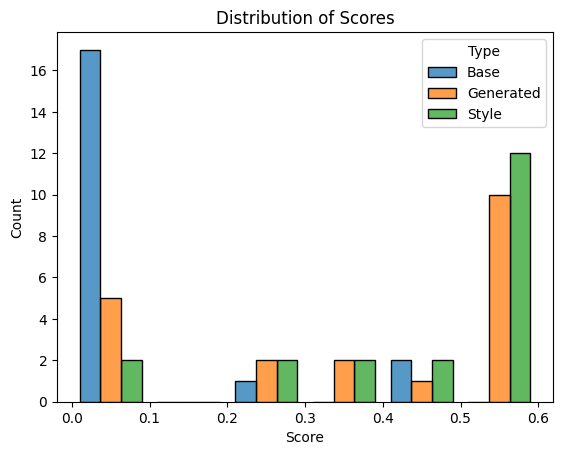

In [27]:
import seaborn as sns
import pandas as pd

# Create clean DataFrame
df = pd.DataFrame({
    'Score': [*base_scores, *generated_scores, *style_scores],
    'Type': ['Base']*len(base_scores) + ['Generated']*len(generated_scores) + ['Style']*len(style_scores)
})

# Plot with seaborn
sns.histplot(data=df, x='Score', hue='Type', multiple="dodge", bins=6, shrink=.8)

plt.title('Distribution of Scores')
plt.show()

In [28]:
# DO NOT CHANGE/MODIFY THIS CELL.
# EXECUTE IT BEFORE SUBMITTING YOUR ENTRY TO THE LAB.

yoda_test_text = mdl.lab3.yoda_test_text
tokens = tokenizer(yoda_test_text, return_tensors="pt").to(model.device)

# Get the loglikelihood from the model
with torch.no_grad():
    outputs = model(**tokens)
    logits = outputs.logits[:, :-1]
    targets = tokens.input_ids[:, 1:]
    loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)),
                            targets.reshape(-1))

print(f"Yoda test loglikelihood: {loss.item():.2f}")


Yoda test loglikelihood: 2.78
